In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import optuna

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import os
# Seed for reproducibility
from torchmetrics.image.fid import FrechetInceptionDistance
import torch
from torch_fidelity import calculate_metrics


# 初始化Inception模型
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
from scipy.linalg import sqrtm

In [2]:
torch.manual_seed(0)
# 计算两个多维高斯分布之间的Fréchet距离
from torch.utils.data import TensorDataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import Dataset

In [3]:
def calculate_fid(generator, device, data_loader, latent_dim, num_samples=1000):
    fid = FrechetInceptionDistance(feature=64, )  # Initialize FID computation
    generator.eval()

    # Collect real and generated images
    real_count = 0
    fake_count = 0

    with torch.no_grad():
        for real_imgs, _ in data_loader:
            # Convert real images to 3 channels, resize, scale to [0, 255], and convert to uint8
            real_imgs_3ch = real_imgs.repeat(1, 3, 1, 1)
            real_imgs_resized = torch.nn.functional.interpolate(real_imgs_3ch, size=(299, 299), mode='bilinear', align_corners=False)
            real_imgs_uint8 = (real_imgs_resized * 127.5 + 127.5).clamp(0, 255).to(torch.uint8)

            fid.update(real_imgs_uint8.to("cpu"), real=True)
            real_count += real_imgs.size(0)

            # Generate fake images
            z = torch.randn(real_imgs.size(0), latent_dim, device=device)
            labels = torch.randint(0, 10, (real_imgs.size(0),), device=device)
            gen_imgs = generator(z, labels)
            gen_imgs_3ch = gen_imgs.repeat(1, 3, 1, 1)
            gen_imgs_resized = torch.nn.functional.interpolate(gen_imgs_3ch, size=(299, 299), mode='bilinear', align_corners=False)
            gen_imgs_uint8 = (gen_imgs_resized * 127.5 + 127.5).clamp(0, 255).to(torch.uint8)

            fid.update(gen_imgs_uint8.to(("cpu")), real=False)
            fake_count += gen_imgs.size(0)

            if real_count >= num_samples and fake_count >= num_samples:
                break

    fid_score = fid.compute()
    return fid_score


In [4]:
def visualize_generated_images(generator, device, latent_dim, lr, result, epoch, num_images=100, ):
    generator.eval()  # Set the generator to evaluation mode
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, device=device)
        labels = [i % 10 for i in range(num_images)]
        labels = torch.tensor(labels, device=device)
        generated_images = generator(z, labels).cpu().detach().numpy()

    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    for ax, img in zip(axes.flatten(), generated_images):
        ax.axis('off')
        ax.set_adjustable('box')
        ax.imshow(img.squeeze(), cmap='gray')

    plt.suptitle(f'Generated Images, latent_dim={latent_dim}, lr={lr:.5f}, result={result:.4f}')
    if not os.path.exists(f'/archive/bioinformatics/Zhou_lab/shared/jjin/project/convnet_prize/CVAE/case_imgs/dim_{latent_dim}_lr_{lr:.5f}_epoch_{epoch}'):
        os.makedirs(f'/archive/bioinformatics/Zhou_lab/shared/jjin/project/convnet_prize/CVAE/case_imgs/dim_{latent_dim}_lr_{lr:.5f}_epoch_{epoch}')
    plt.savefig(f'/archive/bioinformatics/Zhou_lab/shared/jjin/project/convnet_prize/CVAE/case_imgs/dim_{latent_dim}_lr_{lr:.5f}_epoch_{epoch}/Generate.png')
    plt.show()

def visualize_latent_space(generator, device, latent_dim, lr, result, epoch, num_points=1000):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_points, latent_dim, device=device)
        labels = torch.randint(0, 10, (num_points,), device=device)
        generated_images = generator(z, labels).view(num_points, -1).cpu().detach().numpy()

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(generated_images)
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels.cpu().numpy(), cmap='tab10', edgecolor='k')
    plt.title(f'PCA, latent_dim={latent_dim}, lr={lr:.5f}, result={result:.4f}')
    plt.colorbar()
    plt.savefig(
        f'/archive/bioinformatics/Zhou_lab/shared/jjin/project/convnet_prize/CVAE/case_imgs/dim_{latent_dim}_lr_{lr:.5f}_epoch_{epoch}/PCA.png')
    plt.show()

    # t-SNE
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(generated_images)
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels.cpu().numpy(), cmap='tab10', edgecolor='k')
    # plt.title('t-SNE of Generated Images')
    plt.title(f't-SNE, latent_dim={latent_dim}, lr={lr:.5f}, result={result:.4f}')
    plt.colorbar()
    plt.savefig(
        f'/archive/bioinformatics/Zhou_lab/shared/jjin/project/convnet_prize/CVAE/case_imgs/dim_{latent_dim}_lr_{lr:.5f}_epoch_{epoch}/TSNE.png')
    plt.show()

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = 7  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.model = nn.Sequential(
            nn.Linear(num_classes + 784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

def train(generator, discriminator, device, data_loader, optimizer_G, optimizer_D, criterion, latent_dim, num_epochs=10):
    generator.train()
    discriminator.train()
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(data_loader):
            batch_size = imgs.shape[0]
            valid = torch.ones(batch_size, 1, device=device, requires_grad=False)
            fake = torch.zeros(batch_size, 1, device=device, requires_grad=False)

            real_imgs = imgs.to(device)
            labels = labels.to(device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, 10, (batch_size,), device=device)
            gen_imgs = generator(z, gen_labels)
            g_loss = criterion(discriminator(gen_imgs, gen_labels), valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion(discriminator(real_imgs, labels), valid)
            fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

def train_and_evaluate(generator, discriminator, device, data_loader, optimizer_G, optimizer_D, criterion, latent_dim, num_epochs=10):
    generator.train()
    discriminator.train()

    d_losses = []
    g_losses = []

    discriminator_accuracy_list = []
    FID_score_list = []
    for epoch in range(num_epochs):
        total_g_loss = 0
        total_d_loss = 0
        total_d_correct = 0  # Total discriminator correct predictions
        total_d_count = 0  # Total discriminator predictions

        for imgs, labels in data_loader:
            batch_size = imgs.size(0)
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            real_imgs = imgs.to(device)
            labels = labels.to(device)

            # Training Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, 10, (batch_size,), device=device)
            gen_imgs = generator(z, gen_labels)
            g_loss = criterion(discriminator(gen_imgs, gen_labels), valid)
            g_loss.backward()
            optimizer_G.step()
            total_g_loss += g_loss.item()

            # Training Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion(discriminator(real_imgs, labels), valid)
            fake_loss = criterion(discriminator(gen_imgs.detach(), gen_labels), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            total_d_loss += d_loss.item()

            # Evaluate discriminator accuracy
            with torch.no_grad():
                preds_real = discriminator(real_imgs, labels) >= 0.5
                preds_fake = discriminator(gen_imgs.detach(), gen_labels) < 0.5
                total_d_correct += (preds_real.sum() + preds_fake.sum()).item()
                total_d_count += 2 * batch_size

        avg_g_loss = total_g_loss / len(data_loader)
        avg_d_loss = total_d_loss / len(data_loader)
        discriminator_accuracy = total_d_correct / total_d_count

        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        discriminator_accuracy_list.append(discriminator_accuracy)

        fid_score = 0
        visualize_generated_images(generator, device, latent_dim, lr, fid_score, epoch)
        # visualize_latent_space(generator, device, latent_dim, lr, fid_score, epoch)
        FID_score_list.append(fid_score)
        # print(f"FID score: {fid_score}")

    # Combine generator and discriminator loss, adjust based on discriminator accuracy
        print(f"FID Score: {fid_score} Generator Loss: {avg_g_loss:.4f}, Discriminator Loss: {avg_d_loss:.4f}, Discriminator Accuracy: {discriminator_accuracy:.4f}")

    return d_losses, g_losses, discriminator_accuracy_list, FID_score_list


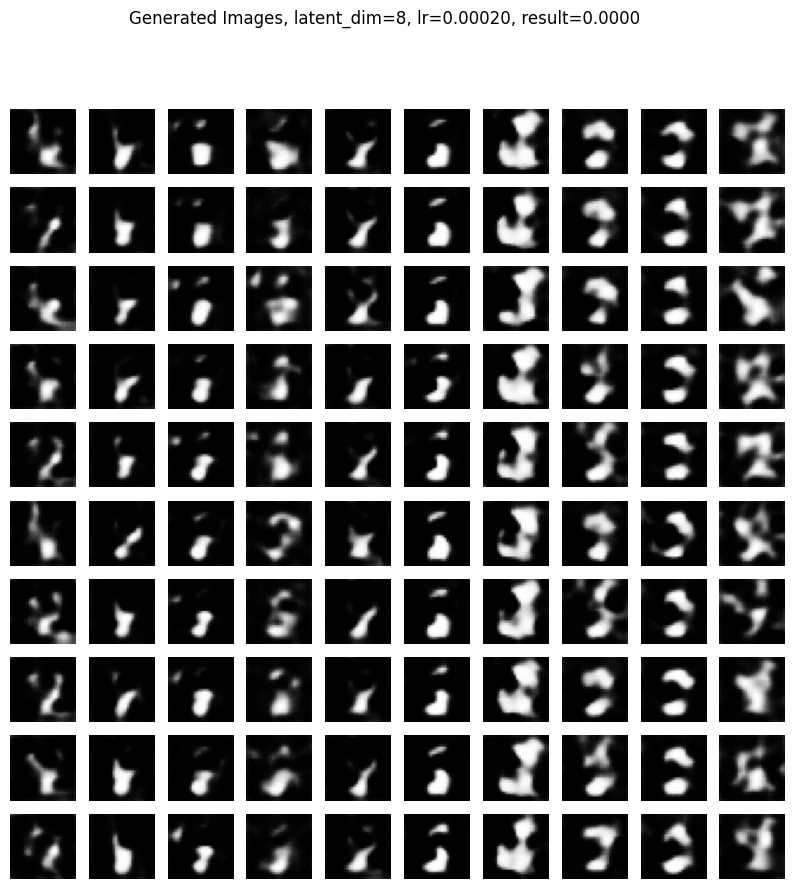

FID Score: 0 Generator Loss: 1.7668, Discriminator Loss: 0.4771, Discriminator Accuracy: 0.8081


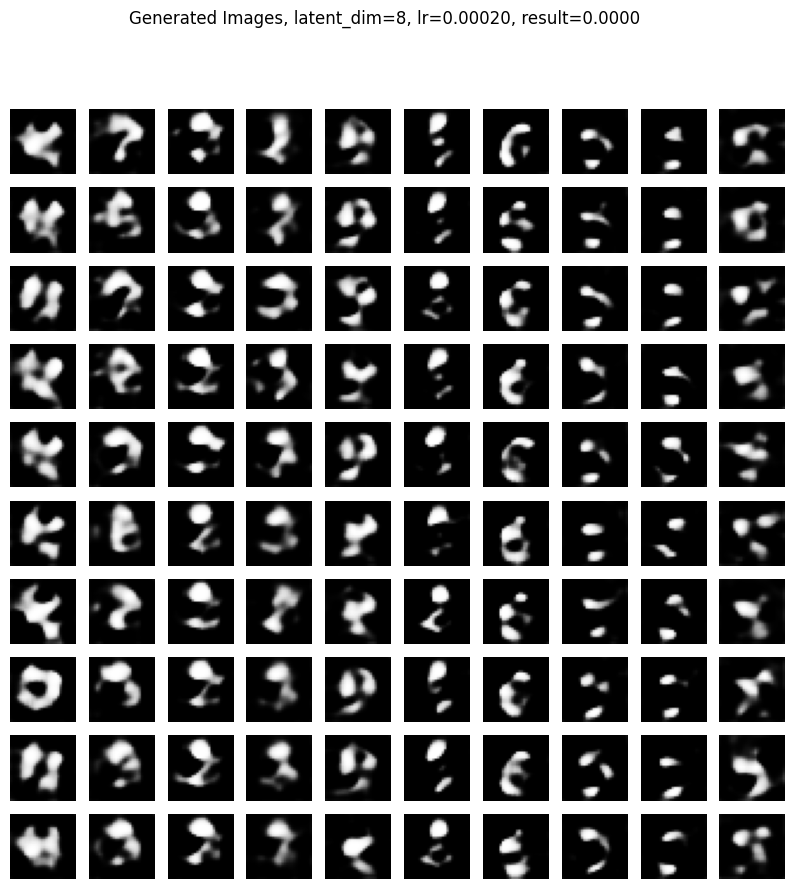

FID Score: 0 Generator Loss: 1.8826, Discriminator Loss: 0.4669, Discriminator Accuracy: 0.8079


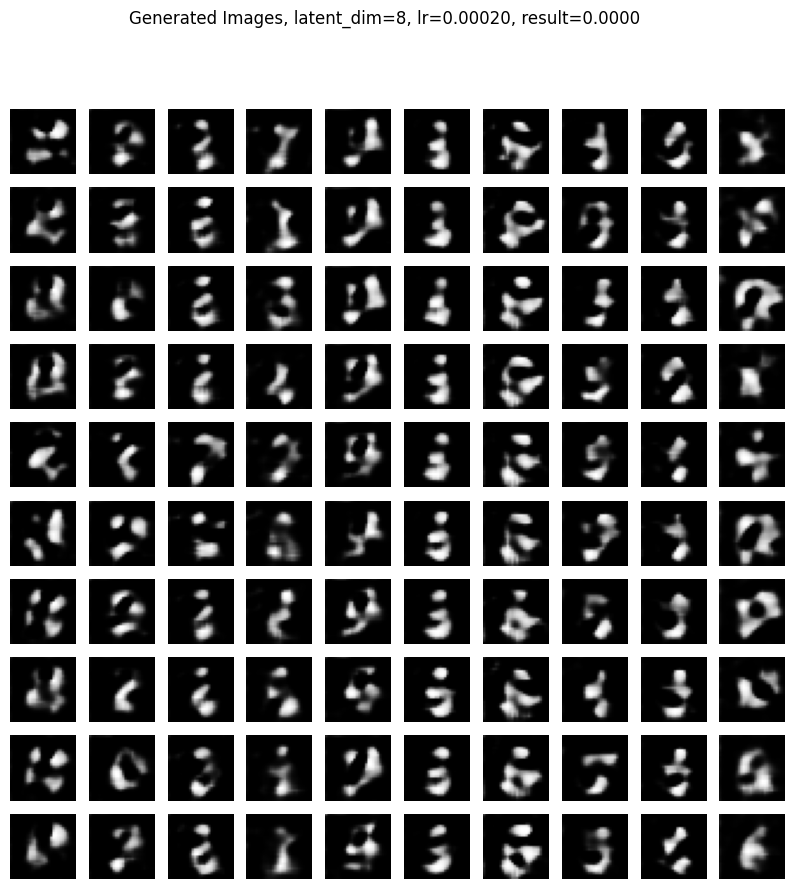

FID Score: 0 Generator Loss: 1.5051, Discriminator Loss: 0.5480, Discriminator Accuracy: 0.7651


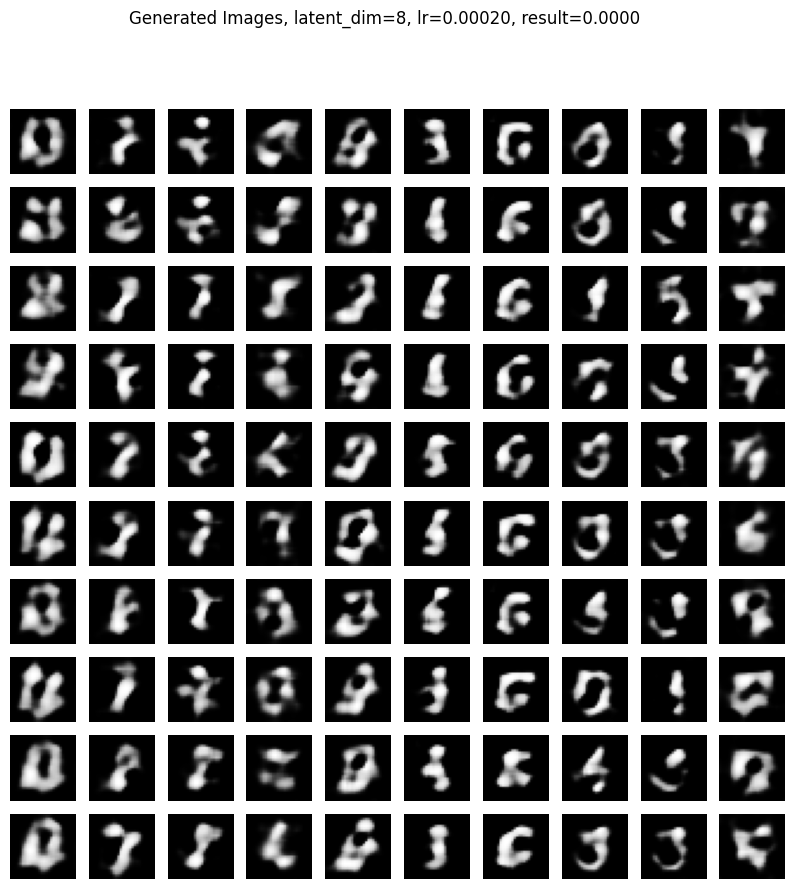

FID Score: 0 Generator Loss: 1.2210, Discriminator Loss: 0.5576, Discriminator Accuracy: 0.7351


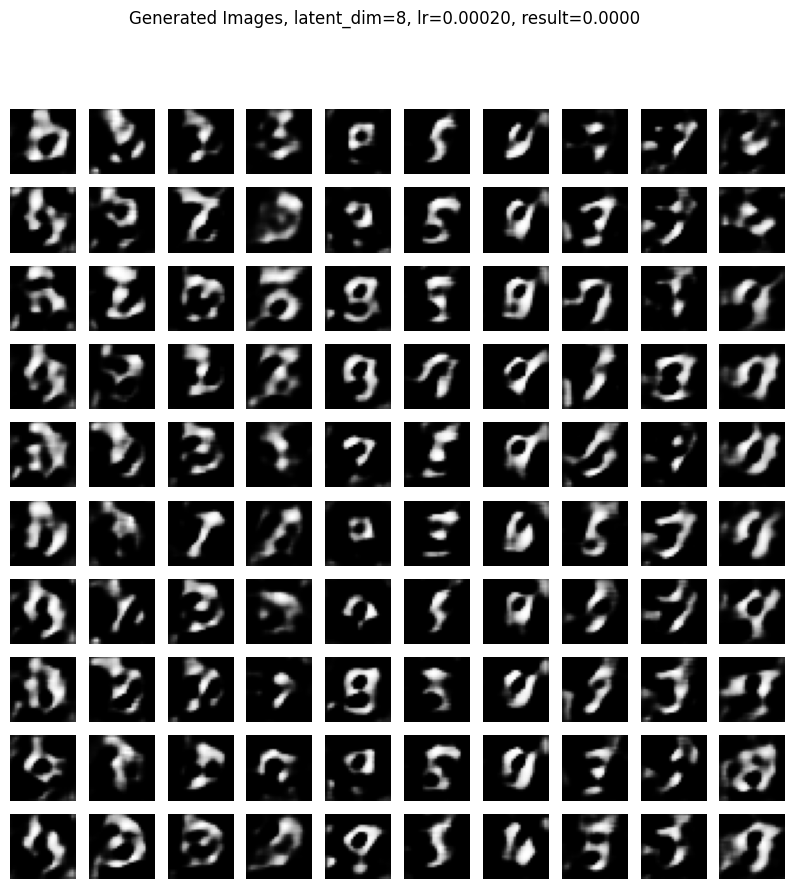

FID Score: 0 Generator Loss: 1.5583, Discriminator Loss: 0.4791, Discriminator Accuracy: 0.7923


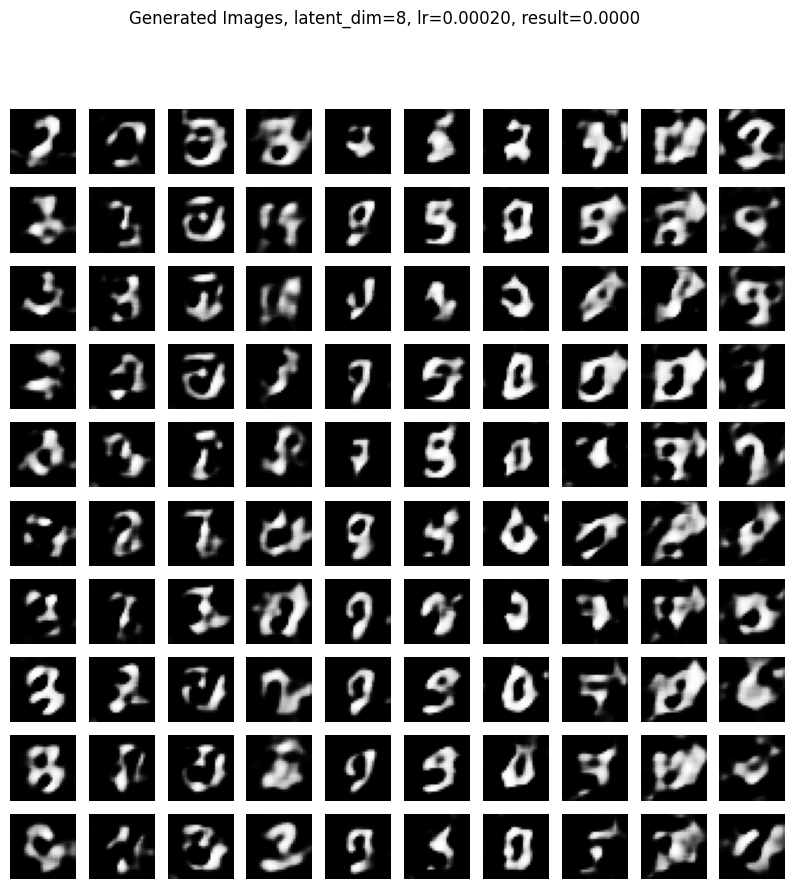

FID Score: 0 Generator Loss: 1.4770, Discriminator Loss: 0.4631, Discriminator Accuracy: 0.8053


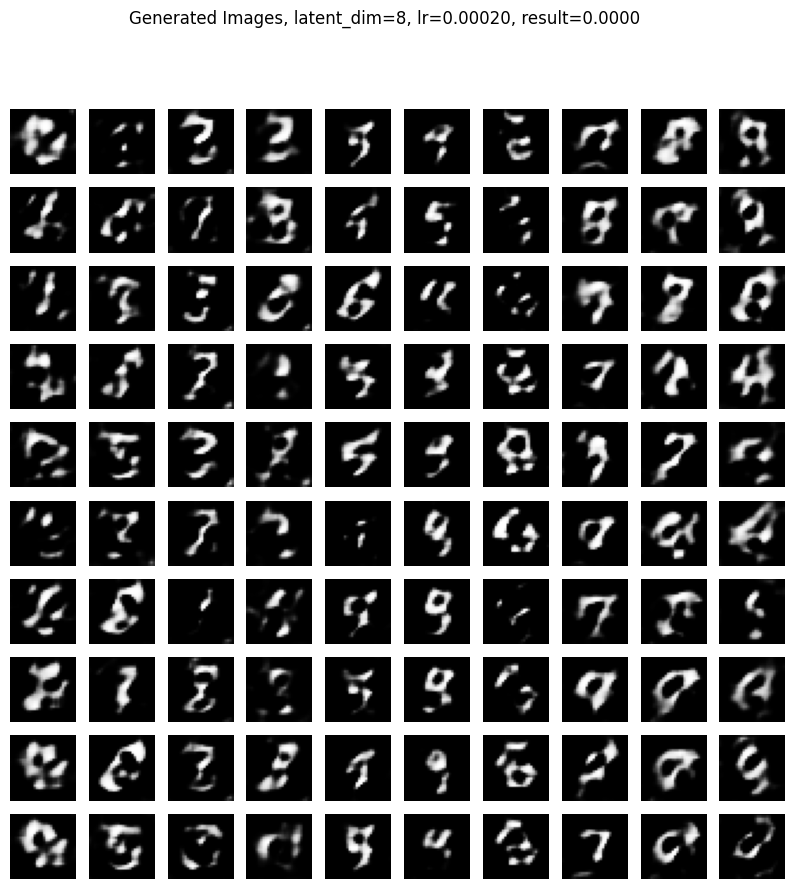

FID Score: 0 Generator Loss: 1.6594, Discriminator Loss: 0.4306, Discriminator Accuracy: 0.8214


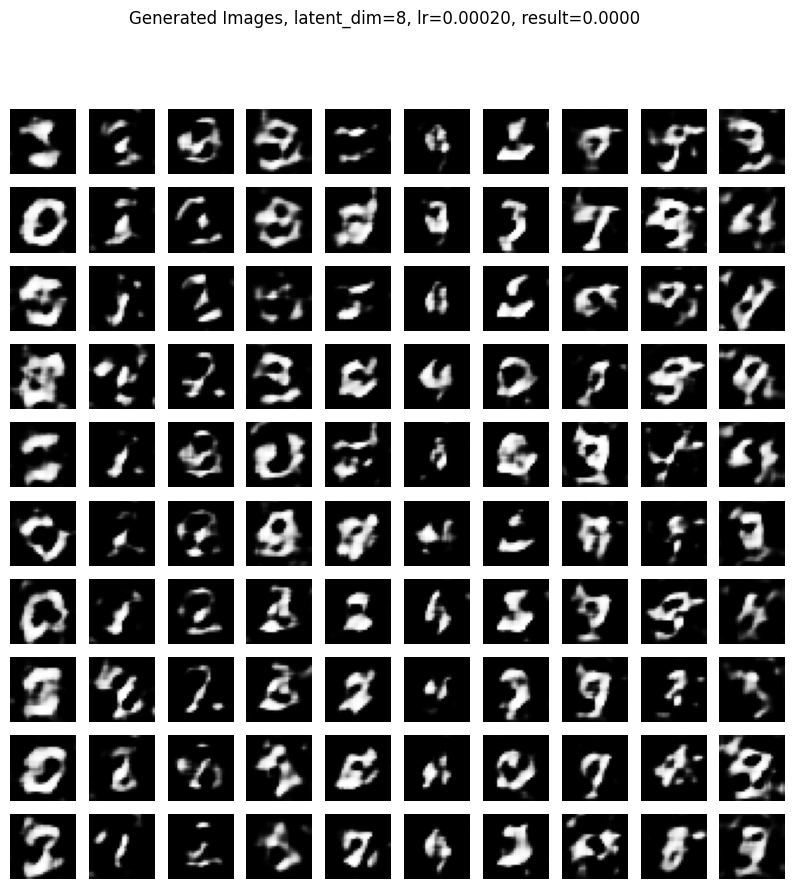

FID Score: 0 Generator Loss: 1.5786, Discriminator Loss: 0.4310, Discriminator Accuracy: 0.8190


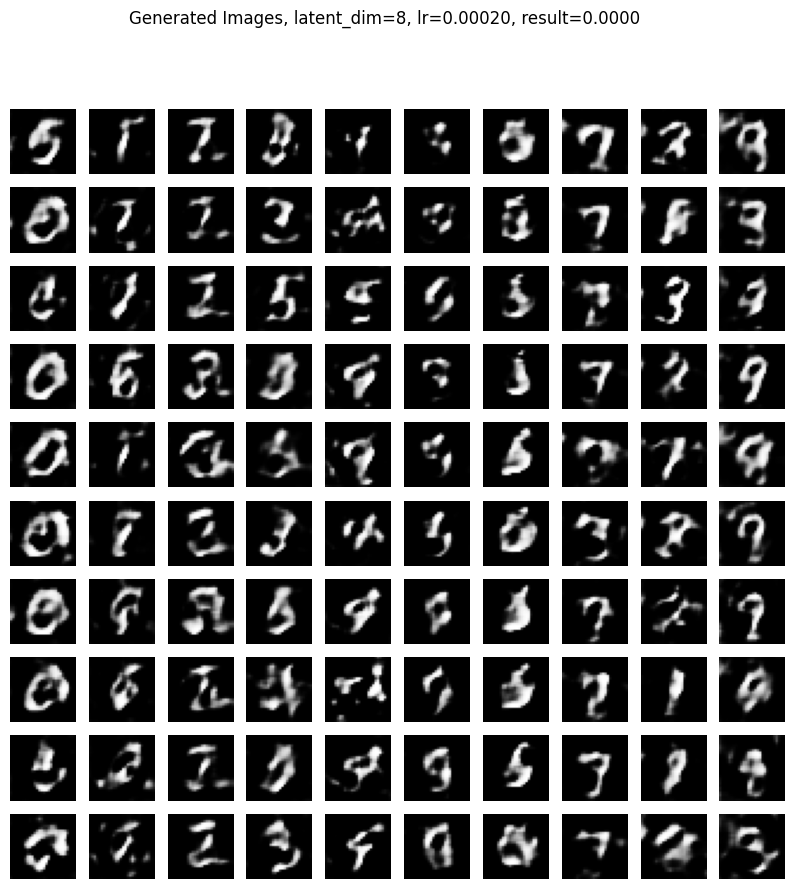

FID Score: 0 Generator Loss: 1.7076, Discriminator Loss: 0.4044, Discriminator Accuracy: 0.8377


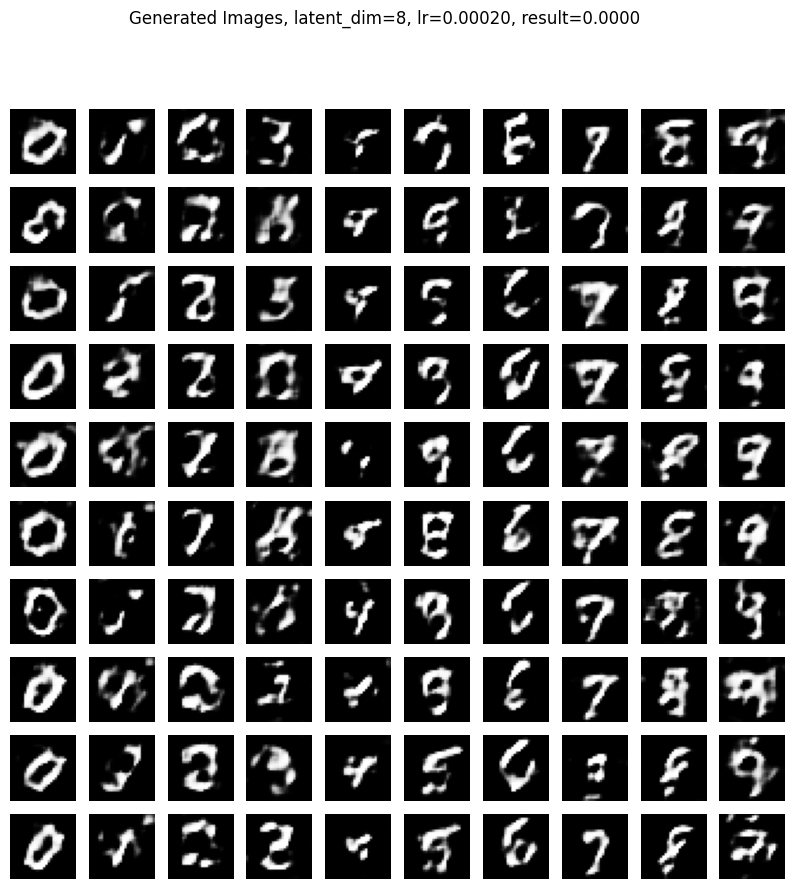

FID Score: 0 Generator Loss: 1.6510, Discriminator Loss: 0.4035, Discriminator Accuracy: 0.8361


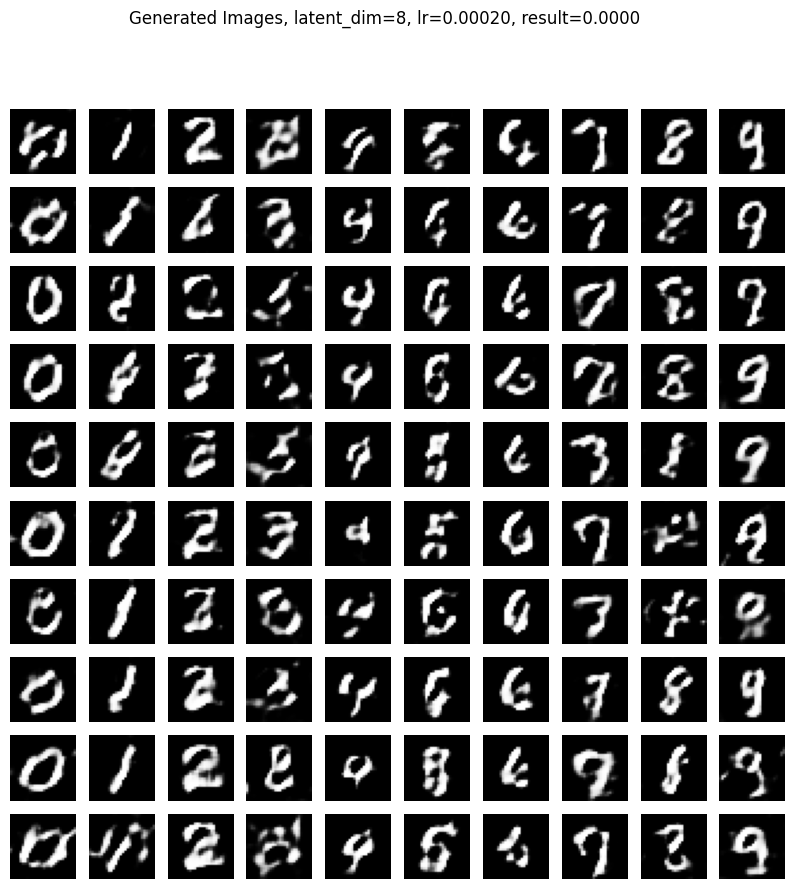

FID Score: 0 Generator Loss: 1.6296, Discriminator Loss: 0.4176, Discriminator Accuracy: 0.8255


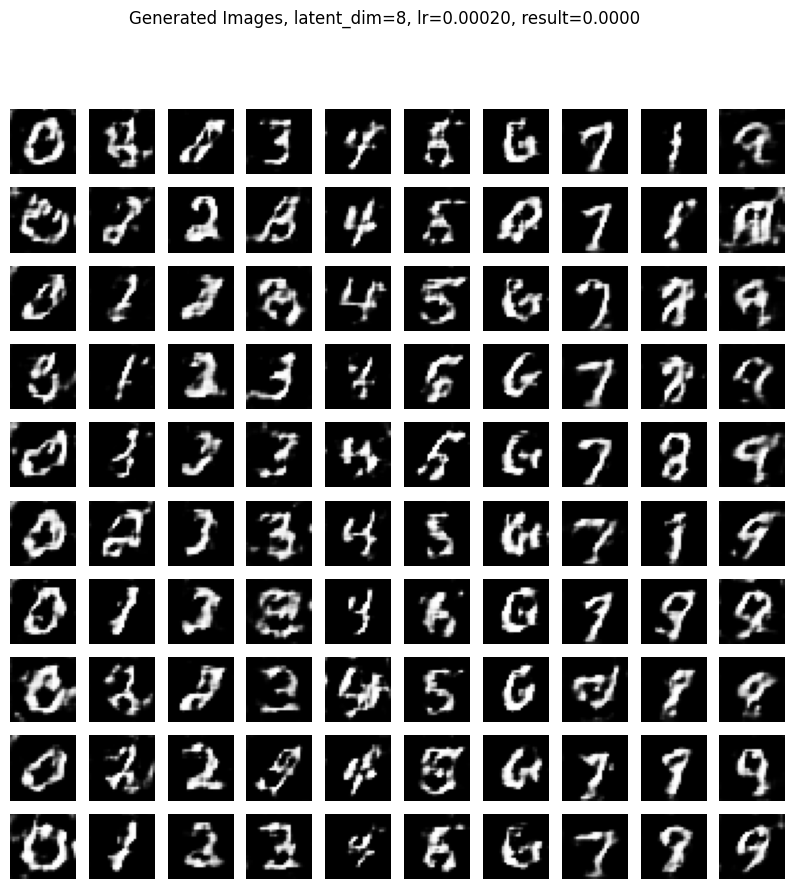

FID Score: 0 Generator Loss: 1.6815, Discriminator Loss: 0.4145, Discriminator Accuracy: 0.8260


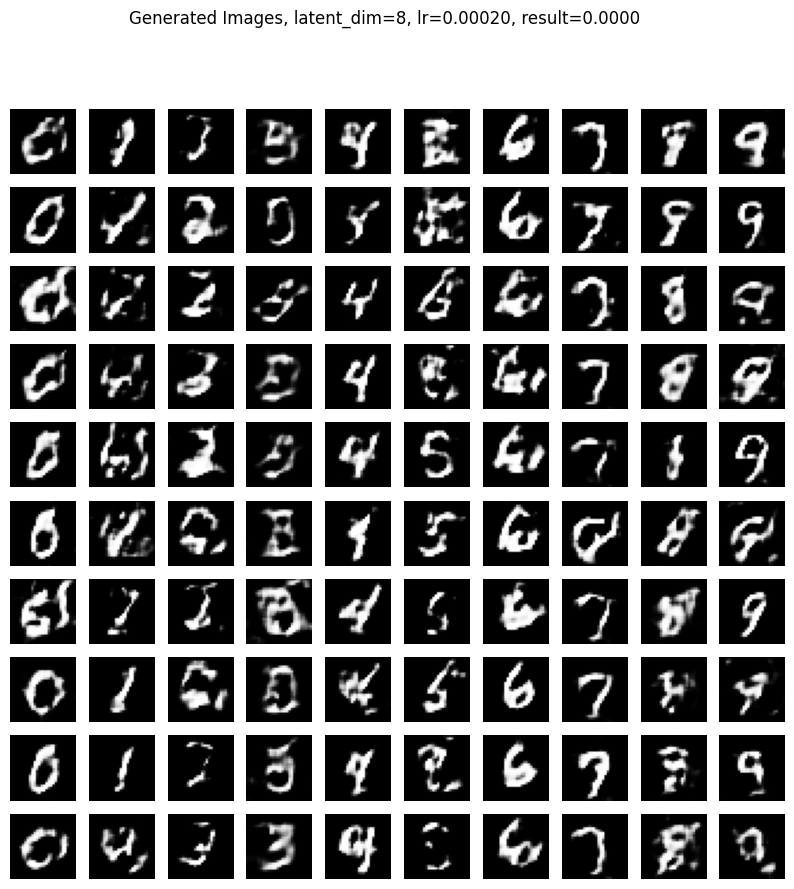

FID Score: 0 Generator Loss: 1.5173, Discriminator Loss: 0.4438, Discriminator Accuracy: 0.8056


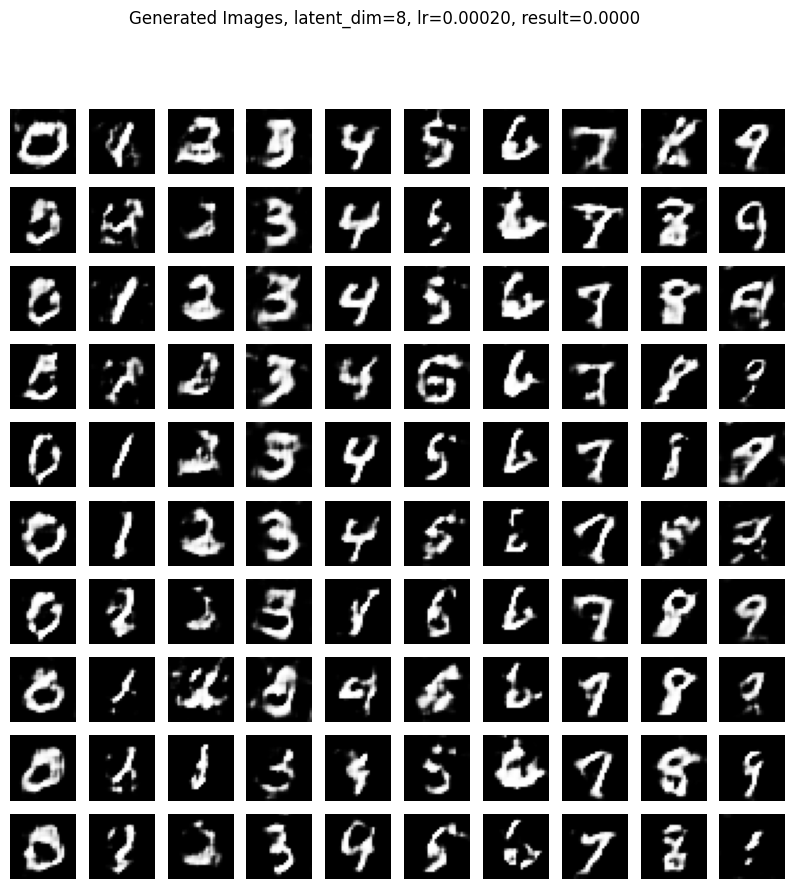

FID Score: 0 Generator Loss: 1.4333, Discriminator Loss: 0.4695, Discriminator Accuracy: 0.7877


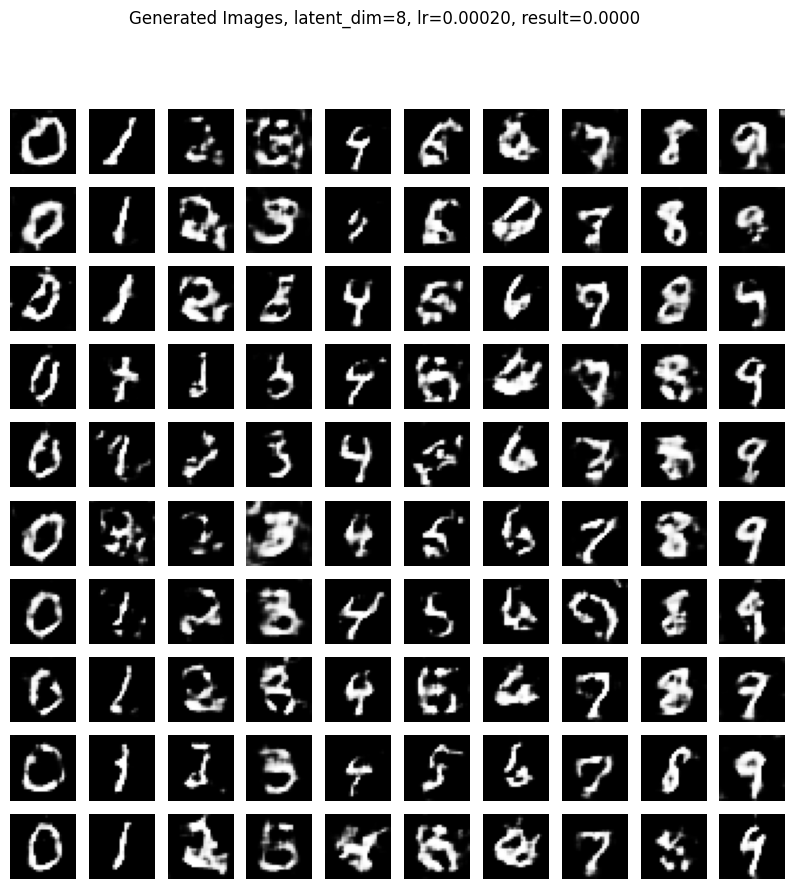

FID Score: 0 Generator Loss: 1.3293, Discriminator Loss: 0.4949, Discriminator Accuracy: 0.7710


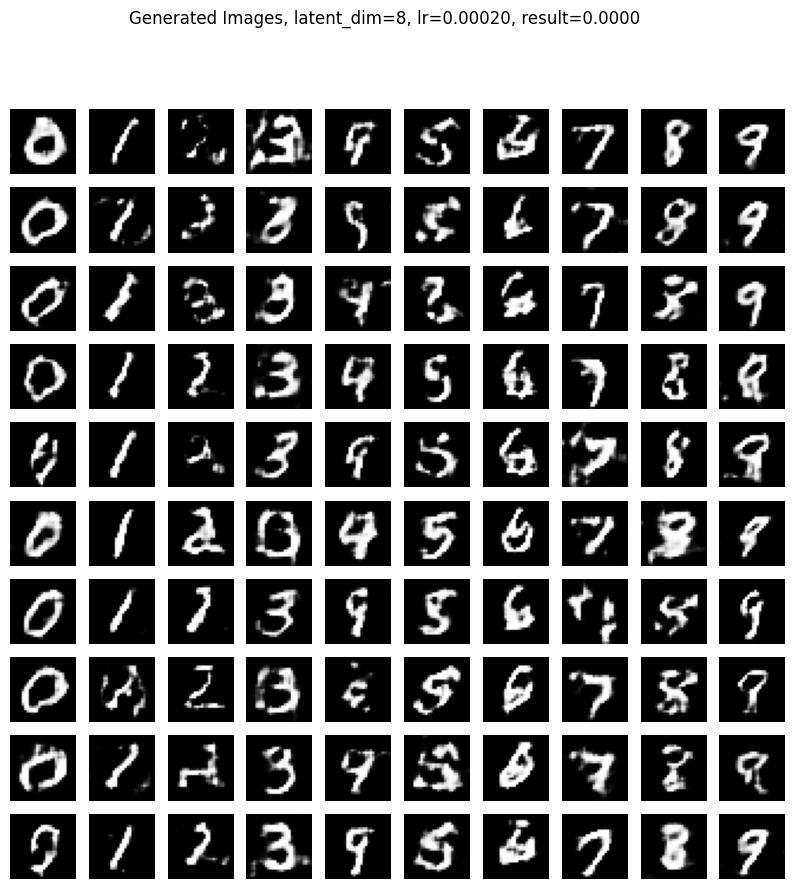

FID Score: 0 Generator Loss: 1.2012, Discriminator Loss: 0.5346, Discriminator Accuracy: 0.7415


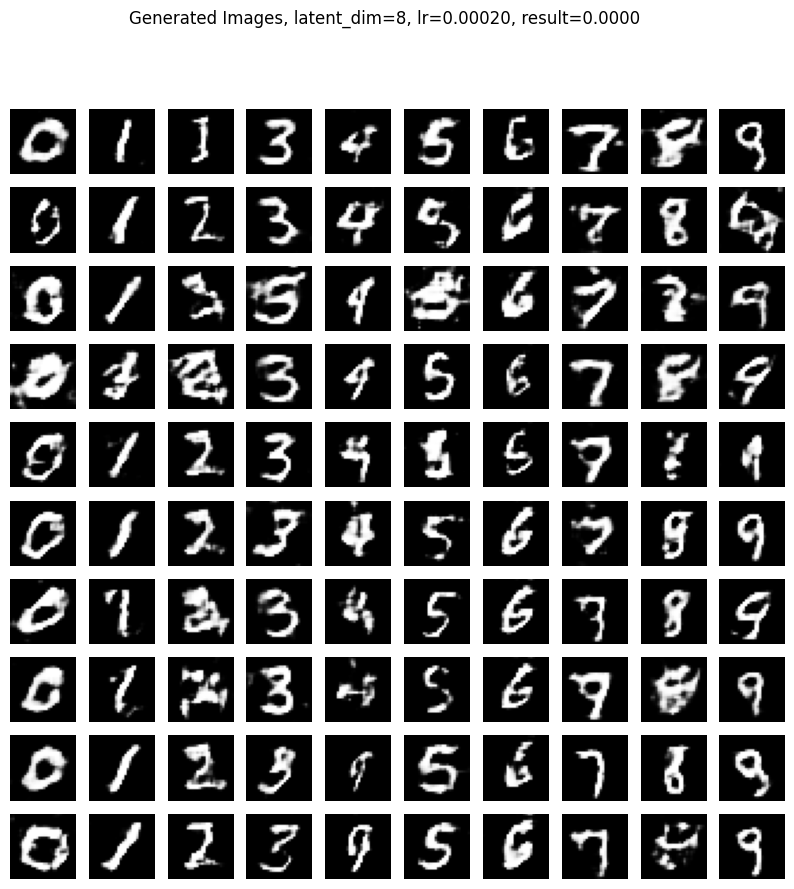

FID Score: 0 Generator Loss: 1.1428, Discriminator Loss: 0.5456, Discriminator Accuracy: 0.7326


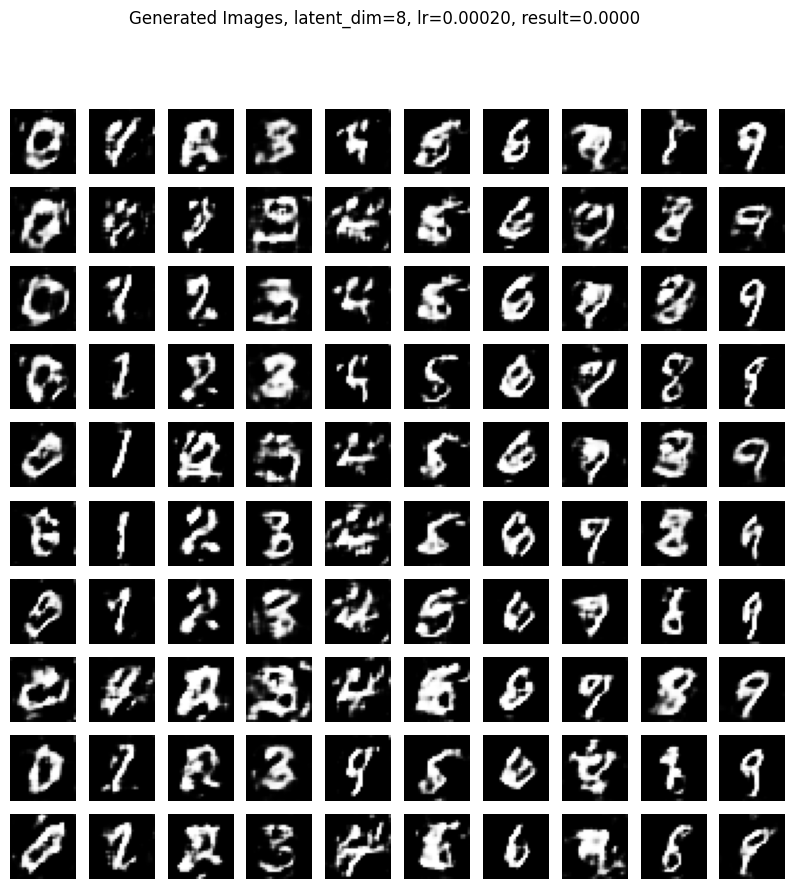

FID Score: 0 Generator Loss: 1.0545, Discriminator Loss: 0.5777, Discriminator Accuracy: 0.7077


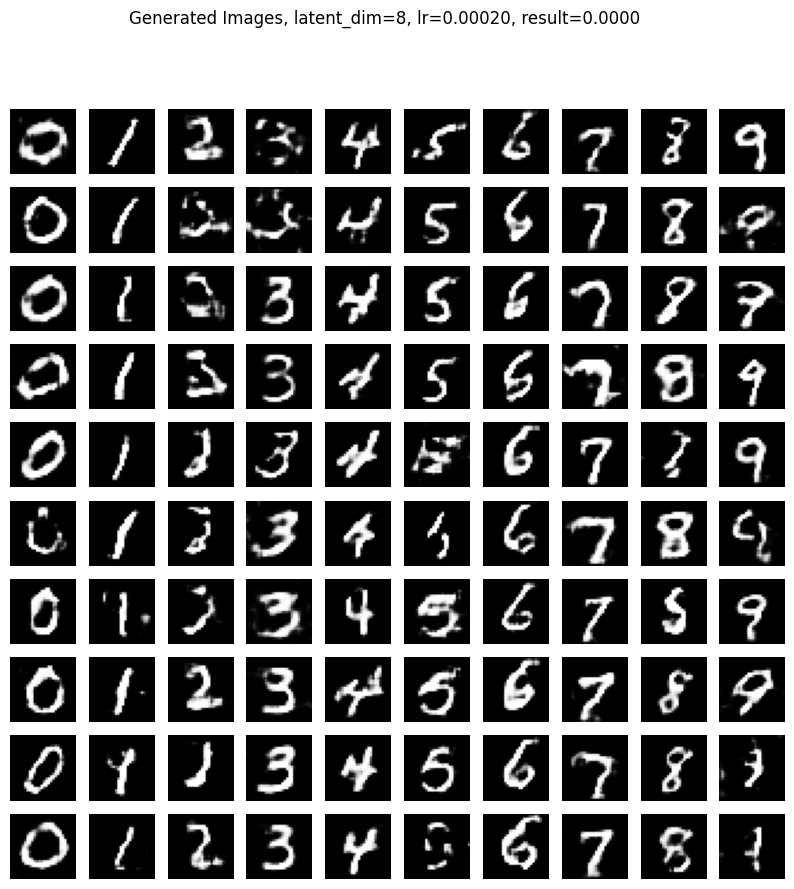

FID Score: 0 Generator Loss: 1.0041, Discriminator Loss: 0.5873, Discriminator Accuracy: 0.6978


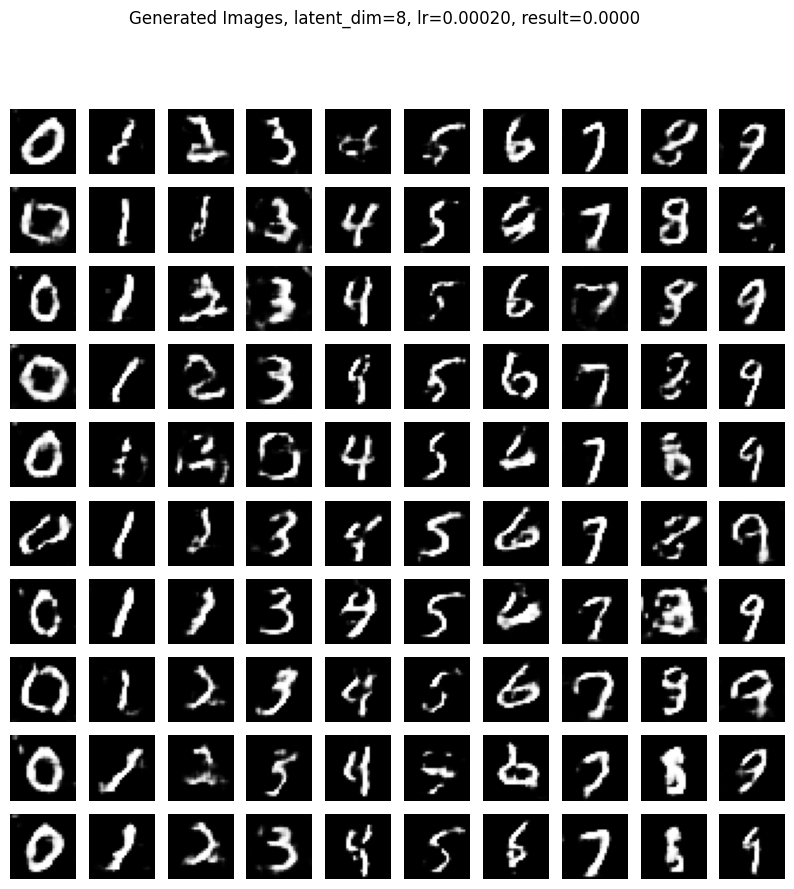

FID Score: 0 Generator Loss: 0.9595, Discriminator Loss: 0.6054, Discriminator Accuracy: 0.6801


In [5]:
latent_dim = 8
lr = 0.0001

# Model, optimizer, and dataloader setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
dataset = torchvision.datasets.MNIST('/archive/bioinformatics/Zhou_lab/shared/jjin/project/convnet_prize/CVAE/', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Training
# train(generator, discriminator, device, data_loader, optimizer_G, optimizer_D, criterion, latent_dim, num_epochs=10)
# In the objective function, replace the evaluation call
d_losses, g_losses, discriminator_accuracy_list, FID_score_list = train_and_evaluate(generator, discriminator, device, data_loader, optimizer_G, optimizer_D, criterion,
                            latent_dim, num_epochs=20)

In [19]:
# modify two dimension value and generate images to see what two dimension represent
def explore_latent_space(generator, device, dim_range=(-2, 2), steps=10, fixed_label=0):
    generator.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients for this
        # Create a grid of values within the specified range for each dimension
        values = np.linspace(dim_range[0], dim_range[1], steps)
        values_others = torch.randn(1, latent_dim-2, device=device)
        
        fig, axes = plt.subplots(nrows=steps, ncols=steps, figsize=(10, 10))
        for i, val1 in enumerate(values):
            for j, val2 in enumerate(values):
                # Set latent vector: vary one dimension across the row, the other across the column
                z = torch.tensor([[val1, val2]], dtype=torch.float32).to(device)
                z = torch.cat((z, values_others), dim=1)
                # Generate an image from the latent vector
                image = generator(z, torch.tensor([fixed_label]).to(device)).cpu().view(28, 28)  # Adjust the view to match your generator's output shape
                ax = axes[i, j]
                ax.imshow(image, cmap='gray')
                ax.axis('off')

        plt.show()

In [23]:
def explore_latent_space_V1(generator, device, dim_range=(-2, 2), steps=10, fixed_label=0):
    generator.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients for this
        # Create a grid of values within the specified range for each dimension
        values = np.linspace(dim_range[0], dim_range[1], steps)
        values_others = torch.randn(1, latent_dim-2, device=device)
        
        fig, axes = plt.subplots(nrows=steps, ncols=steps, figsize=(10, 10))
        for i, val1 in enumerate(values):
            for j, val2 in enumerate(values):
                # Set latent vector: vary one dimension across the row, the other across the column
                z = torch.tensor([[val1, val2]], dtype=torch.float32).to(device)
                z = torch.cat((values_others, z), dim=1)
                # Generate an image from the latent vector
                image = generator(z, torch.tensor([fixed_label]).to(device)).cpu().view(28, 28)  # Adjust the view to match your generator's output shape
                ax = axes[i, j]
                ax.imshow(image, cmap='gray')
                ax.axis('off')

        plt.show()

In [18]:
z = torch.tensor([[1, 2]], dtype=torch.float32).to(device)
print(z.shape)
values_others = torch.randn(1,latent_dim-2, device=device)
print(values_others.shape)
z = torch.cat((z, values_others), dim=1)
print(z.shape)

torch.Size([1, 2])
torch.Size([1, 6])
torch.Size([1, 8])


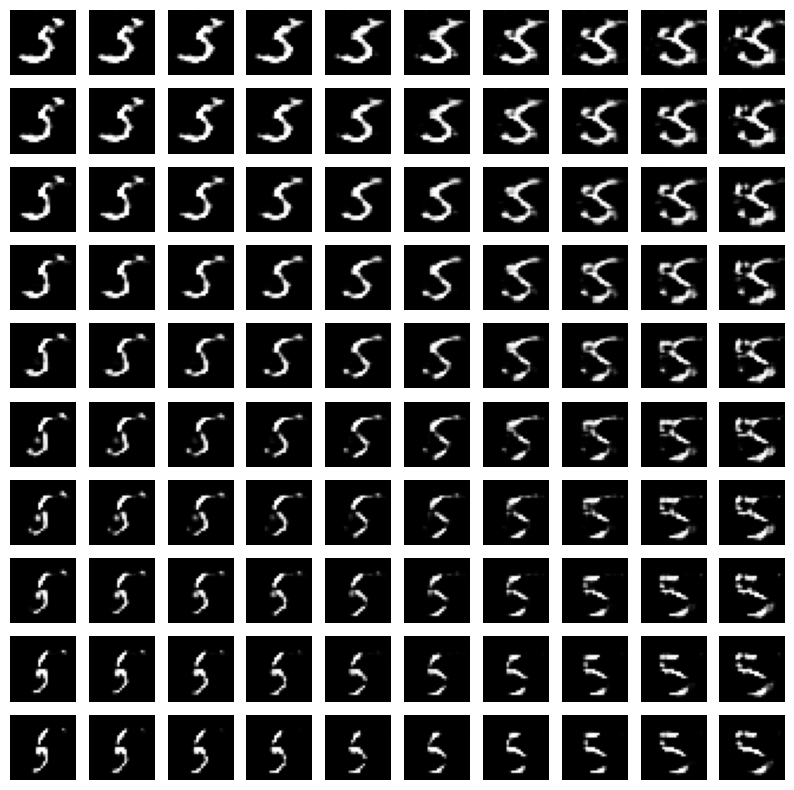

In [25]:
explore_latent_space(generator, device, dim_range=(-3, 3), steps=10, fixed_label=5)

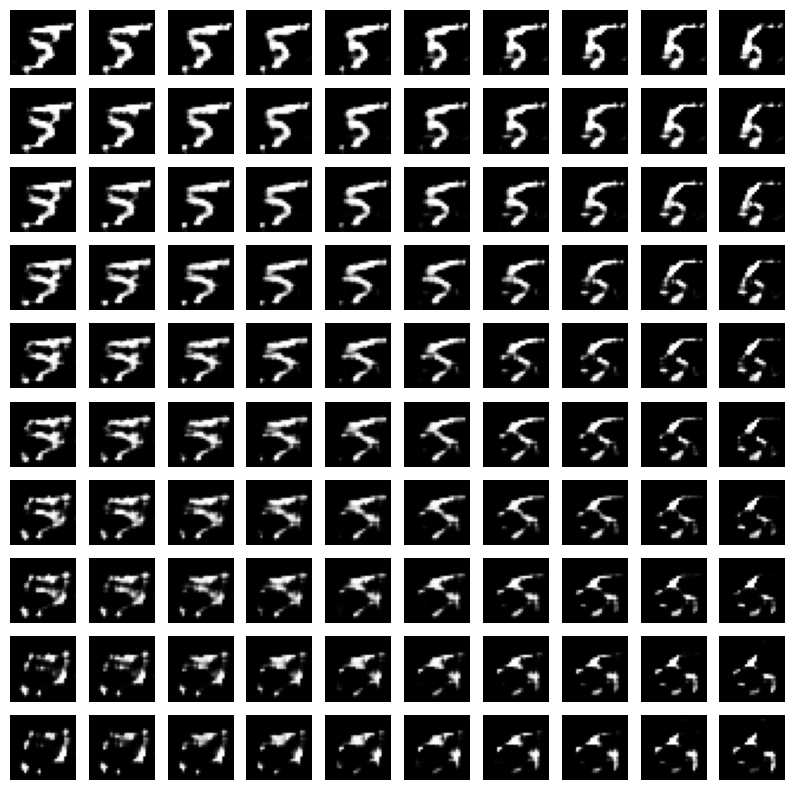

In [26]:
explore_latent_space_V1(generator, device, dim_range=(-3, 3), steps=10, fixed_label=5)